# 20220327-zoo-stats
- Cumulative statistics (weighted over simpoints)
    - Accuracy
    - Coverage
    - IPC improvement (over no prefetcher)
    - MPKI reduction (over no prefetcher)
    - DRAM bandwidth reduction (over no prefetcher)
- Collecting statistics (from `Pythia` directory):
    - Create Zoo sweep by running `./experiments/prefetcher_zoo.py condor_setup`
    - Evaluate Zoo sweep by running `./experiments/prefetcher_zoo.py eval`
    - If tuning prefetchers by degree:
        1. Create degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py condor_setup`
        2. Evaluate degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py eval`
        3. Copy degree tuning ChampSim result files to the Zoo sweep ChampSim results directory
        4. Evaluate combined sweep by running `./experiments/prefetcher_zoo.py eval --best-degree-csv <output of (2)>`

In [54]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

from utils import utils

In [55]:
data_path = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo.csv'
data_path_cs = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo_cloudsuite.csv'
weight_path = '/scratch/cluster/cmolder/traces/prefetcher_zoo/champsim/weights.txt'

gap = [
    'cc', 'pr', 'sssp', 'bfs', 'tc'
]
spec = [
    'astar', 'bwaves', 'bzip2', 'cactusADM', 'calculix',
    'gcc', 'GemsFDTD', 'hmmer', 'lbm', 'leslie3d',
    'libquantum', 'mcf', 'milc', 'omnetpp', 'soplex',
    'sphinx3', 'tonto', 'wrf', 'xalancbmk'
]
cloudsuite = [
    'cassandra_core0', 'cassandra_core1', 'cassandra_core2', 'cassandra_core3',
    'classification_core0', 'classification_core1', 'classification_core2', 'classification_core3',
    'cloud9_core0', 'cloud9_core1', 'cloud9_core2', 'cloud9_core3',
    'nutch_core0', 'nutch_core1', 'nutch_core2', 'nutch_core3',
    'streaming_core0', 'streaming_core1', 'streaming_core2', 'streaming_core3'
]
    

df = utils.read_data_file(data_path)
df_cs = utils.read_data_file(data_path_cs)
df = df.append(df_cs)
weights = utils.read_weights_file(weight_path)

In [56]:
df

,full_trace,trace,simpoint,prefetcher,degree,accuracy,coverage,mpki,mpki_reduction,dram_bw_epochs,dram_bw_reduction,ipc,ipc_improvement,baseline_prefetcher,path,baseline_path
0,astar_163B,astar,163B,bingo_bo,"(None, None)",15.508980,28.070636,0.98736,50.258942,384334,7.680815,0.53898,7.871510,no,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...
1,astar_163B,astar,163B,bingo,"(None,)",17.140605,28.383891,0.98306,50.475567,384481,7.645505,0.53877,7.829481,no,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...
2,astar_163B,astar,163B,bingo_pythia,"(None, None)",18.014248,30.461579,0.95454,51.912343,383159,7.963056,0.54074,8.223757,no,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...
3,astar_163B,astar,163B,bingo_sisb,"(None, None)",17.357634,29.317831,0.97024,51.121411,384047,7.749754,0.53941,7.957570,no,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...
4,astar_163B,astar,163B,bingo_sms,"(None, None)",18.815663,32.900603,0.92106,53.598992,382615,8.093728,0.54155,8.385870,no,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,streaming_phase5_core3,streaming_core3,phase5,sisb_spp,"(None, None)",82.580736,22.688697,3.60566,30.387020,945236,1.265677,0.21020,1.301205,no,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...
2516,streaming_phase5_core3,streaming_core3,phase5,sisb_pythia,"(None, None)",70.138587,42.099824,2.70036,47.865271,923418,3.544670,0.21526,3.739759,no,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...
2517,streaming_phase5_core3,streaming_core3,phase5,sms_pythia,"(None, None)",66.272140,44.980724,2.56600,50.459304,922487,3.641917,0.21548,3.845783,no,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...
2518,streaming_phase5_core3,streaming_core3,phase5,sms_spp,"(None, None)",74.733556,37.544759,2.91280,43.763780,929719,2.886501,0.21377,3.021687,no,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...,/scratch/cluster/cmolder/prefetcher_zoo/2022_0...


In [57]:
weights

,full_trace,weight,trace,simpoint
0,astar_163B,0.452174,astar,163B
1,astar_23B,0.162319,astar,23B
2,astar_313B,0.220290,astar,313B
3,bwaves_1609B,0.262524,bwaves,1609B
4,bwaves_1861B,0.337187,bwaves,1861B
...,...,...,...,...
184,streaming_phase1_core3,0.166667,streaming_core3,phase1
185,streaming_phase2_core3,0.166667,streaming_core3,phase2
186,streaming_phase3_core3,0.166667,streaming_core3,phase3
187,streaming_phase4_core3,0.166666,streaming_core3,phase4


# Helper functions

In [58]:
def get_longest_simpoints(weights):
    idx = (weights.groupby('trace')['weight'].transform(max) == weights['weight'])
    traces = weights[idx].trace
    return traces

def _process_prefetcher(stats, df, weights, tr, pf):
    wt = weights[weights.trace == tr][['simpoint', 'weight']]
    data = df[(df.trace == tr) & (df.prefetcher == pf)]
    data = data.merge(wt, on='simpoint')
    weights = data['weight'] / sum(data['weight'])

    stats['trace'] = np.append(stats['trace'], tr)
    stats['prefetcher'] = np.append(stats['prefetcher'], pf)
    stats['simpoint'] = np.append(stats['simpoint'], 'weighted')
    
    for metric in utils.metrics:
        target = data[metric].item() if len(data) <= 1 else utils.mean(data[metric], metric, weights=weights)
        stats[f'{metric}'] = np.append(stats[f'{metric}'], target)
        
def _process_phase_combined(stats, df, weights, tr):
    wt = weights[(weights.trace == tr)]
    data = df[(df.trace == tr)]
    
    stats['trace'] = np.append(stats['trace'], tr)
    stats['prefetcher'] = np.append(stats['prefetcher'], 'phase_combined')
    stats['simpoint'] = np.append(stats['simpoint'], 'weighted')            
    for metric in utils.metrics:
        best_metrics = data.groupby('simpoint')[metric].max().to_frame()
        best_metrics = best_metrics.merge(wt, on='simpoint')
        best_metrics['weight'] = best_metrics['weight'] / best_metrics['weight'].sum()

        target = utils.mean(best_metrics[metric], metric, weights=best_metrics['weight'])
        stats[f'{metric}'] = np.append(stats[f'{metric}'], target)
    
def get_weighted_statistics(df, weights, metric, add_phase_combined=True):
    stats = {
        'trace': np.array([]),
        'prefetcher': np.array([]),
        'simpoint': np.array([]),
        'accuracy': np.array([]),
        'coverage': np.array([]),
        'ipc_improvement': np.array([]),
        'mpki_reduction': np.array([]),
        'dram_bw_reduction': np.array([])
    }
    
    for tr in df.trace.unique():
        for pf in df.prefetcher.unique():
            _process_prefetcher(stats, df, weights, tr, pf)
                
        if add_phase_combined:
            _process_phase_combined(stats, df, weights, tr)
               
    return pd.DataFrame(stats)

In [59]:
def plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                               prefetchers=None,
                               benchmarks=None,
                               dpi=192,
                               ymin=None, ymax=None):
    
    # Filter benchmarks (if wanted)
    if benchmarks is not None:
        df = df[df.trace.isin(benchmarks)]
        
    # Filter or weight simpoints  
    if method == 'weighted':
        df = get_weighted_statistics(df, weights, metric, add_phase_combined=True) # Weighted simpoints
    else:
        df = df[df.full_trace.isin(get_longest_simpoints(weights))] # Longest simpoint

    # Filter prefetchers (if wanted) by weighted simpoints
    if prefetchers is not None:
        df = df[df.prefetcher.isin(prefetchers + ['phase_combined'])]
    
    # Plot
    traces = df['trace'].unique()
    num_prefetchers = len(df.groupby('prefetcher'))
    num_traces = len(df.groupby('trace'))
    mean_metric = 'amean' if metric in utils.amean_metrics else 'gmean'
    sep = 3
    
    fig, ax = plt.subplots(figsize=(12, 6), dpi=dpi)
    ax.grid(axis='y', color='lightgray')
    ax.axhline(0, color='black')
    ax.set_axisbelow(True)
    
    if method == 'weighted':
        if prefetchers is not None:
            pf_list = prefetchers + ['phase_combined']
        else:
            pf_list = df.prefetcher.unique()
    else:
        if prefetchers is not None:
            pf_list = prefetchers
        else:
            pf_list = df.prefetcher.unique()

    for i, pf in enumerate(pf_list):
        df_pf = df[df.prefetcher == pf]
        y = df_pf[metric].to_numpy()
        y = np.append(y, utils.mean(y, metric))
        X = np.arange(0, len(y)) * (num_prefetchers + sep) + i
        label = f'({prefetchers.index(pf)+1}) {pf}' if prefetchers is not None and pf != 'phase_combined' else pf
        color = 'blue' if pf == 'phase_combined' else None
        ax.bar(X, y, label=label, color=color)
        
    
    ax.set_xticks(np.arange(0, len(traces) + 1) * (num_prefetchers + sep) + (num_prefetchers)/2)
    ax.set_xticklabels(traces.tolist() + [mean_metric], rotation=45)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    
    fig.suptitle(f'{metric} ({method} simpoint)')
    ax.set_xlabel('Trace')
    ax.set_ylabel(metric)
    ax.set_ylim(ymin=ymin, ymax=ymax) 
    fig.tight_layout()

---
## SPEC '06 cumulative statistics
### Weighted simpoint, top 10

In [60]:
spec_top_10 = utils.rank_prefetchers(df[df.trace.isin(spec)], 'ipc_improvement', 10)
spec_top_10

['sms_pythia',
 'bingo_pythia',
 'bingo_sms',
 'sisb_pythia',
 'bingo_sisb',
 'sms_sisb',
 'bingo_bo',
 'bingo_spp',
 'bo_pythia',
 'sms_spp']

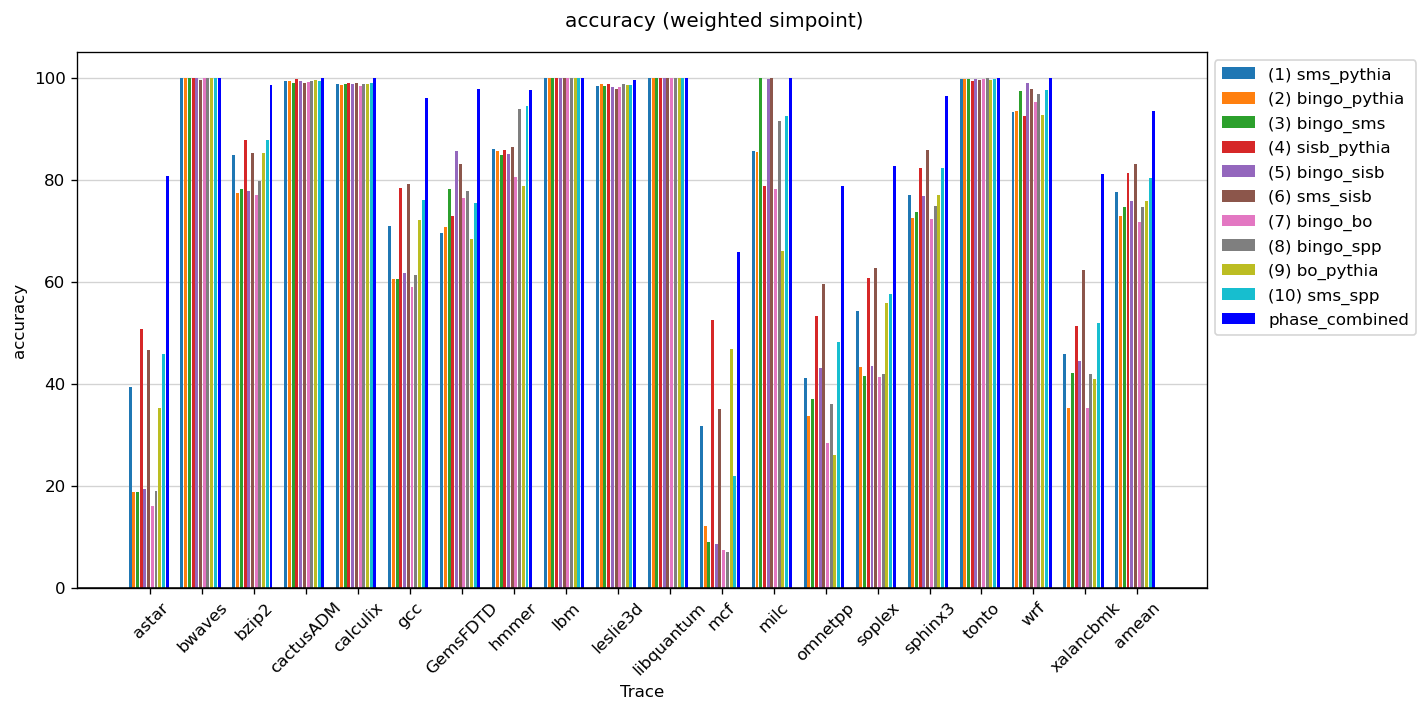

In [61]:
plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                           prefetchers=spec_top_10,
                           benchmarks=spec,
                           ymin=0, ymax=105, dpi=120)

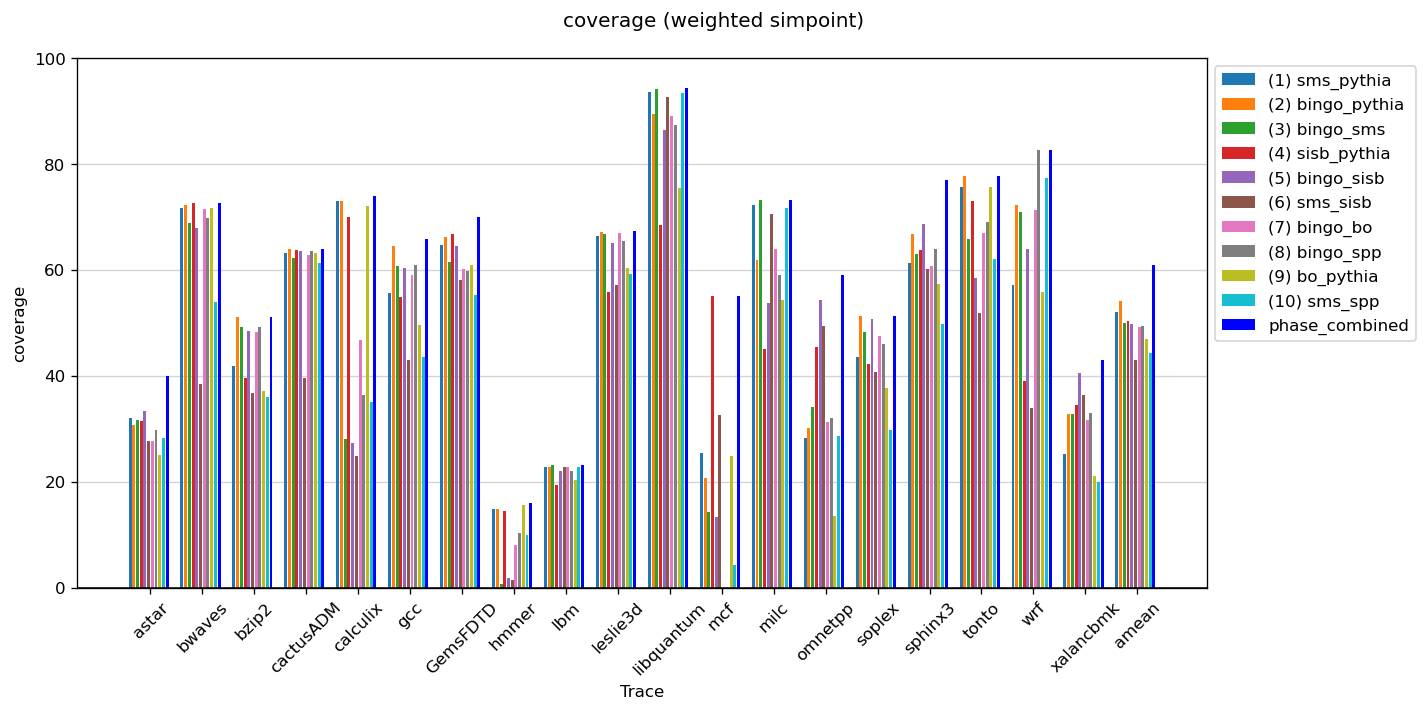

In [62]:
plot_cumulative_statistics(df, weights, metric='coverage', method='weighted',
                           prefetchers=spec_top_10,
                           benchmarks=spec,
                           ymin=0, ymax=100, dpi=120)

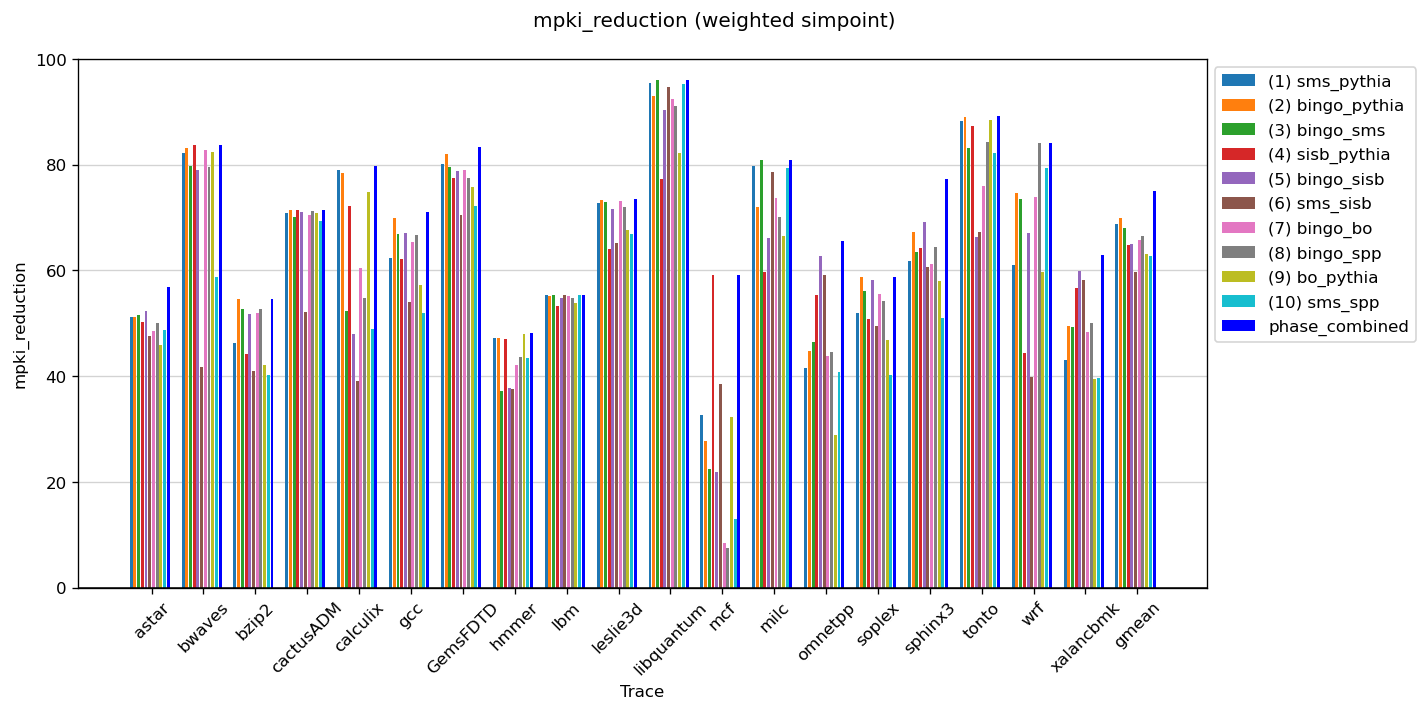

In [63]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           prefetchers=spec_top_10,
                           benchmarks=spec,
                           ymin=0, ymax=100, dpi=120)

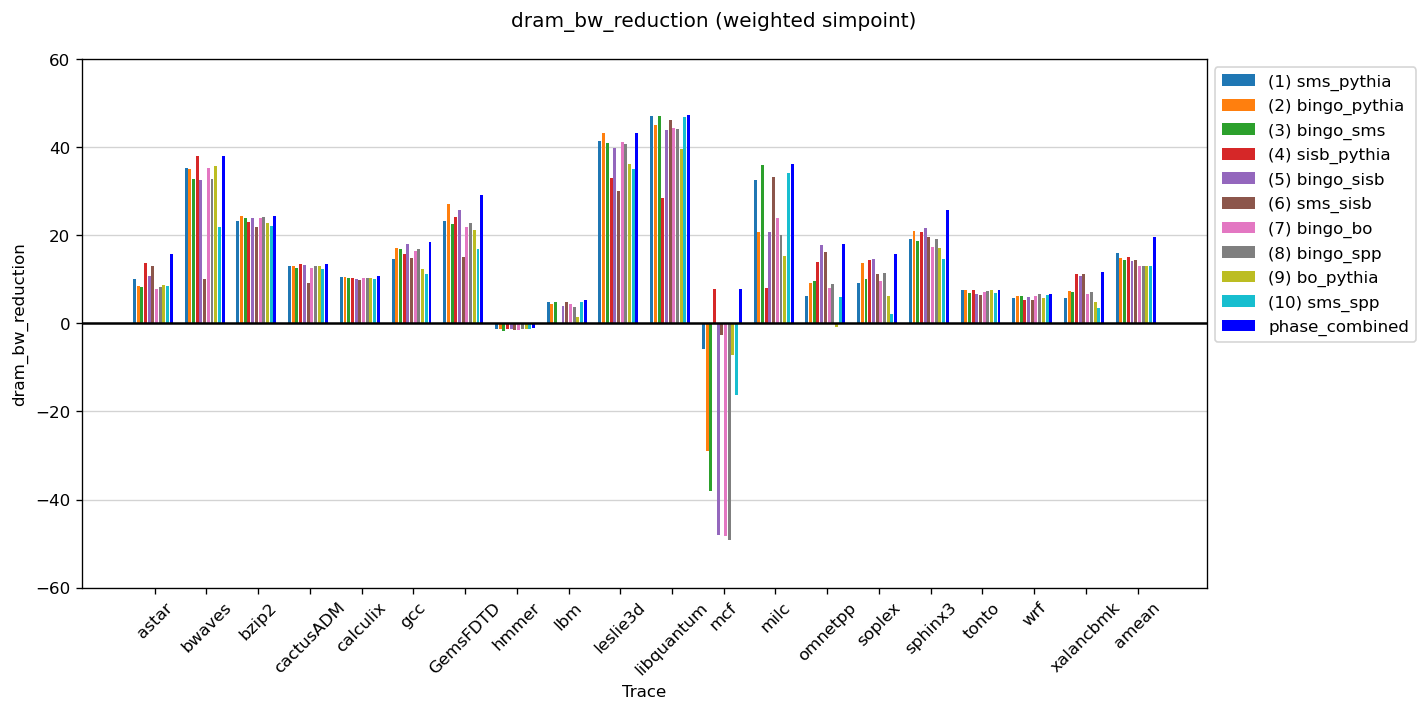

In [64]:
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='weighted',
                           prefetchers=spec_top_10,
                           benchmarks=spec,
                           ymin=-60, ymax=60, dpi=120)

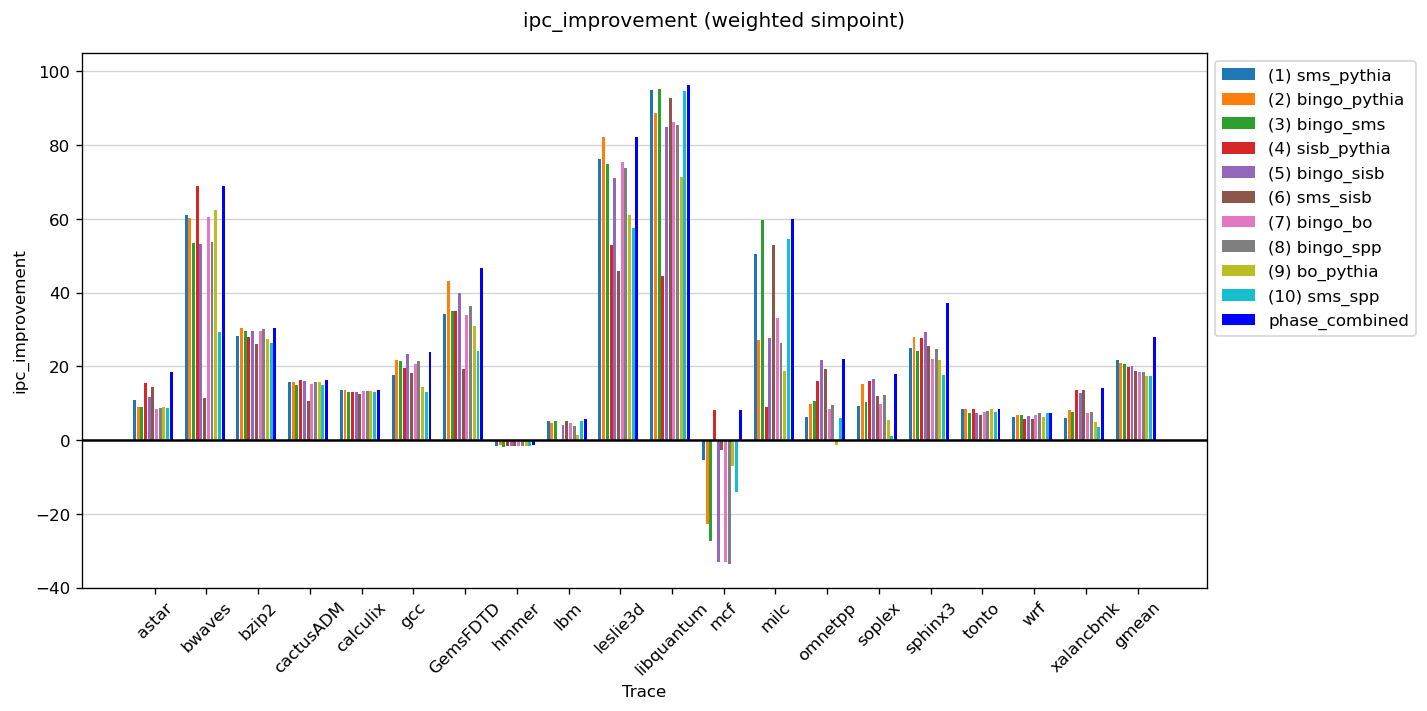

In [65]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           prefetchers=spec_top_10,
                           benchmarks=spec,
                           ymin=-40, ymax=105, dpi=120)

### Weighted simpoint, top 5

In [66]:
spec_top_5 = utils.rank_prefetchers(df[df.trace.isin(spec)], 'ipc_improvement', 5)
spec_top_5

['sms_pythia', 'bingo_pythia', 'bingo_sms', 'sisb_pythia', 'bingo_sisb']

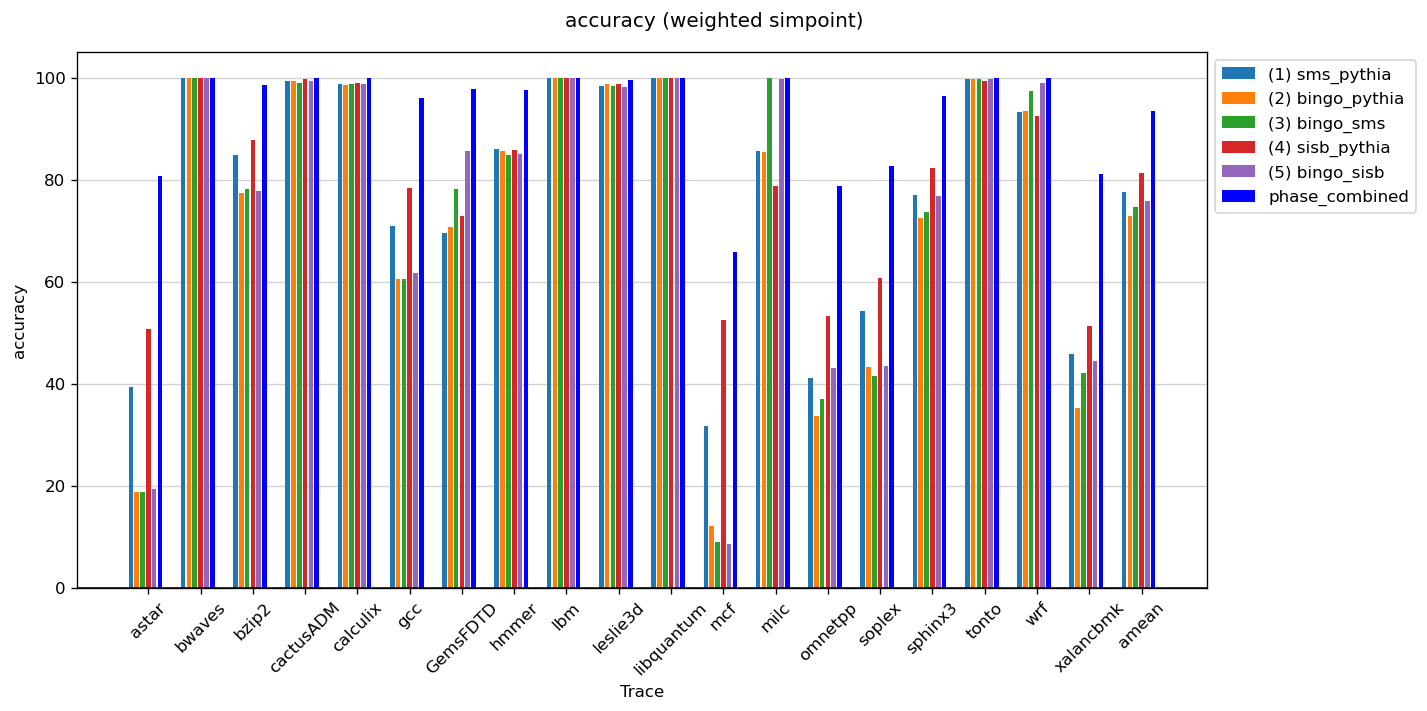

In [67]:
plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                           prefetchers=spec_top_5,
                           benchmarks=spec,
                           ymin=0, ymax=105, dpi=120)
plt.savefig('plots/zoo-stats/accuracy_5_spec.pdf')

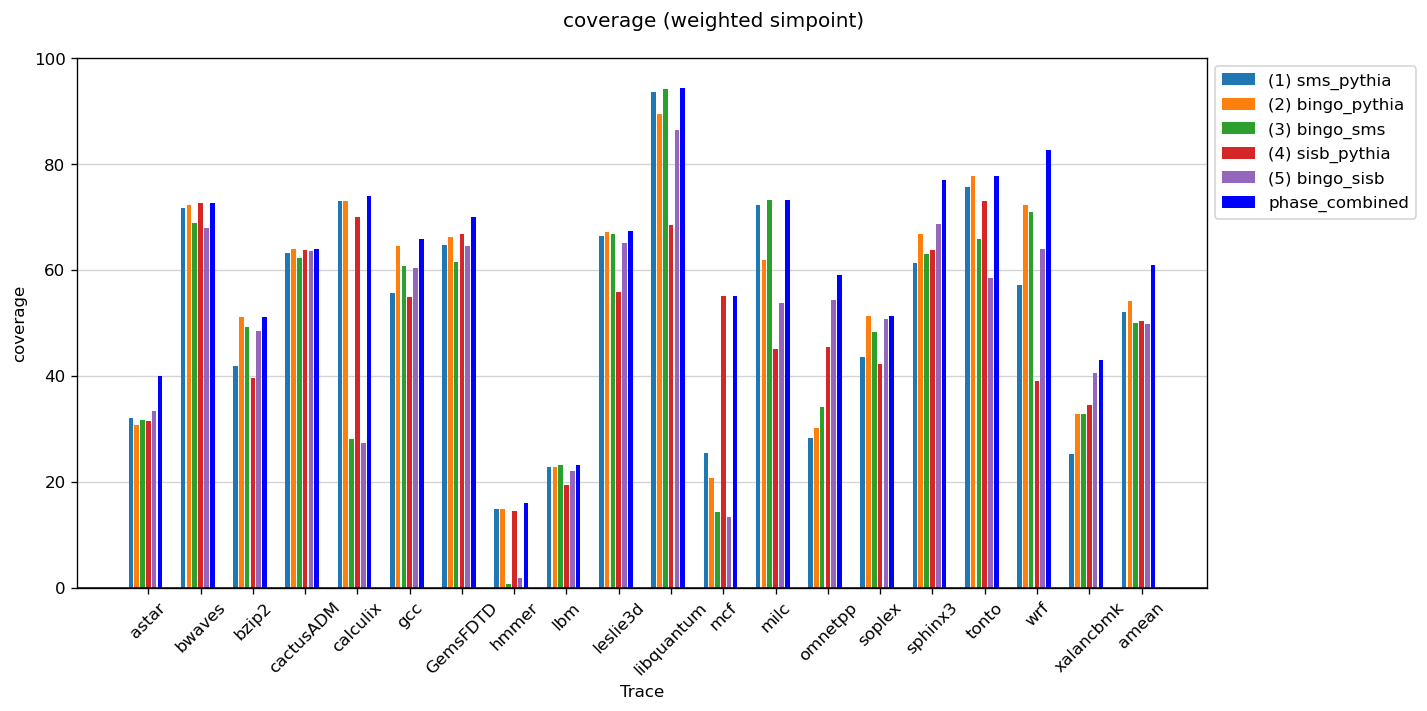

In [68]:
plot_cumulative_statistics(df, weights, metric='coverage', method='weighted',
                           prefetchers=spec_top_5,
                           benchmarks=spec,
                           ymin=0, ymax=100, dpi=120)
plt.savefig('plots/zoo-stats/coverage_5_spec.pdf')

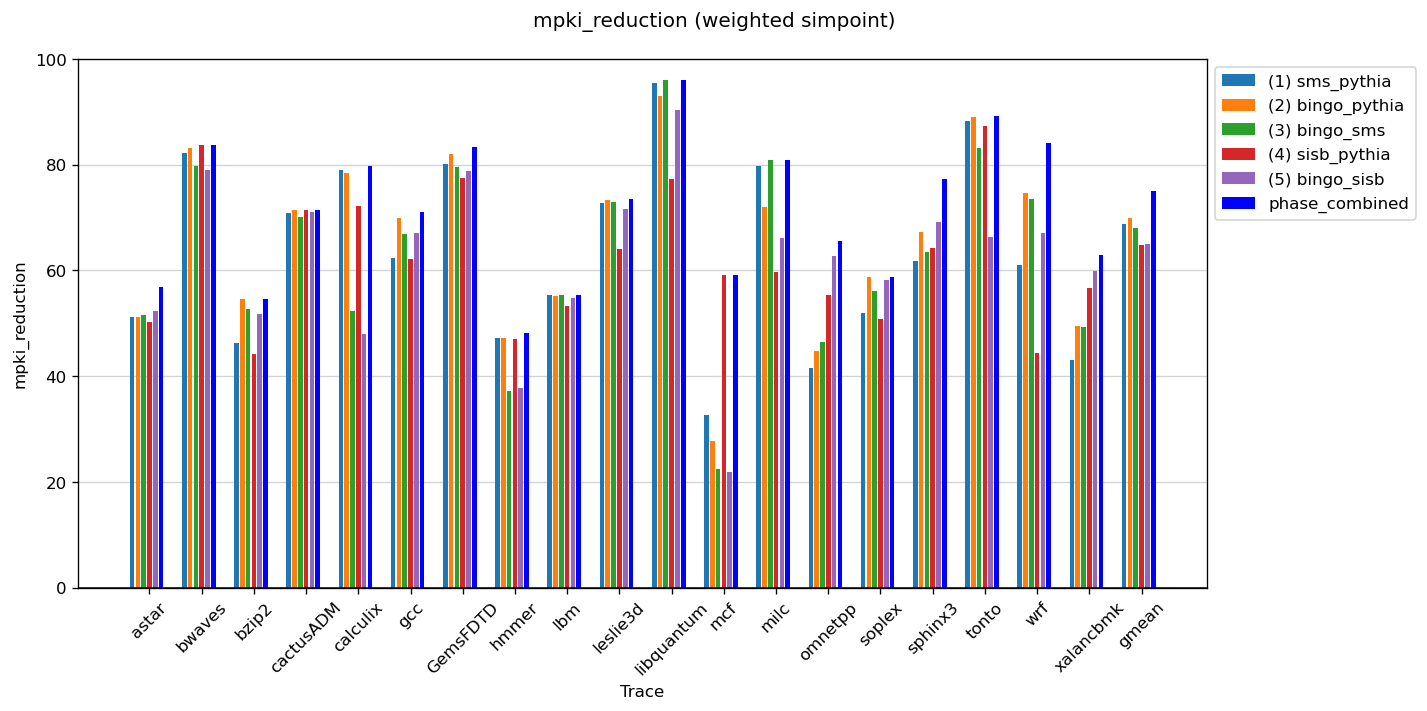

In [69]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           prefetchers=spec_top_5,
                           benchmarks=spec,
                           ymin=0, ymax=100, dpi=120)
plt.savefig('plots/zoo-stats/mpki_reduction_5_spec.pdf')

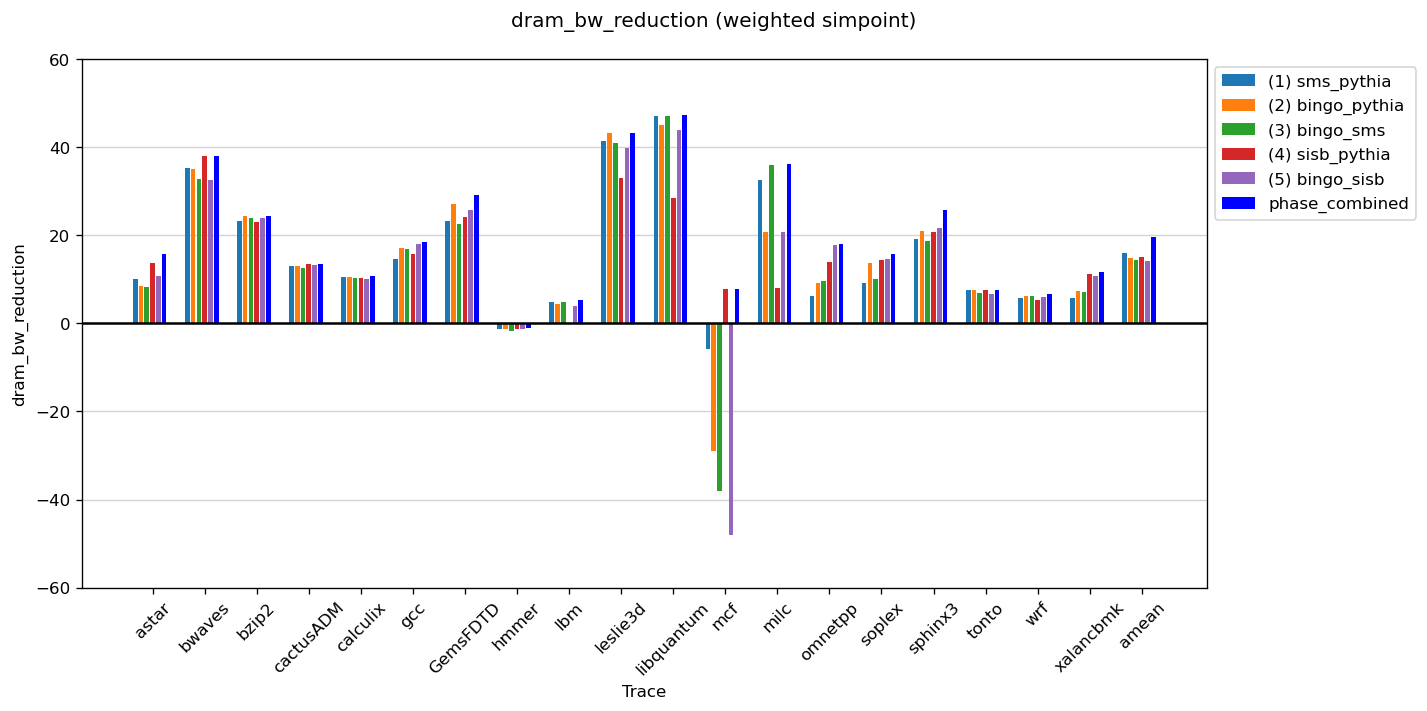

In [70]:
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='weighted',
                           prefetchers=spec_top_5,
                           benchmarks=spec,
                           ymin=-60, ymax=60, dpi=120)
plt.savefig('plots/zoo-stats/dram_bw_reduction_5_spec.pdf')

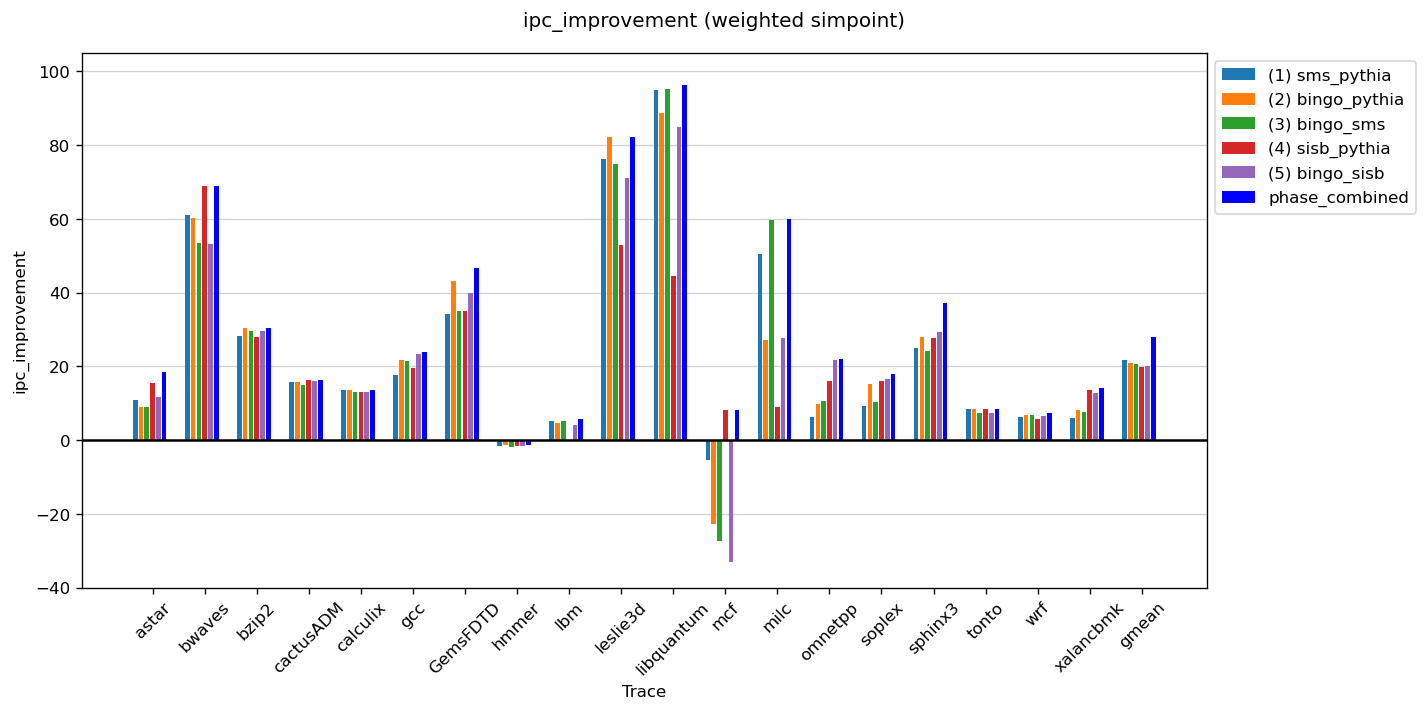

In [71]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           prefetchers=spec_top_5,
                           benchmarks=spec,
                           ymin=-40, ymax=105, dpi=120)
plt.savefig('plots/zoo-stats/ipc_improvement_5_spec.pdf')

### Weighted simpoint, all single prefetchers

In [72]:
spec_top_single = utils.rank_prefetchers(
    df[df.trace.isin(spec) & df.prefetcher.isin(['sisb', 'sms', 'bingo', 'bo', 'spp', 'pythia'])], 
    'ipc_improvement', 6
)
spec_top_single

['bingo', 'pythia', 'sms', 'sisb', 'spp', 'bo']

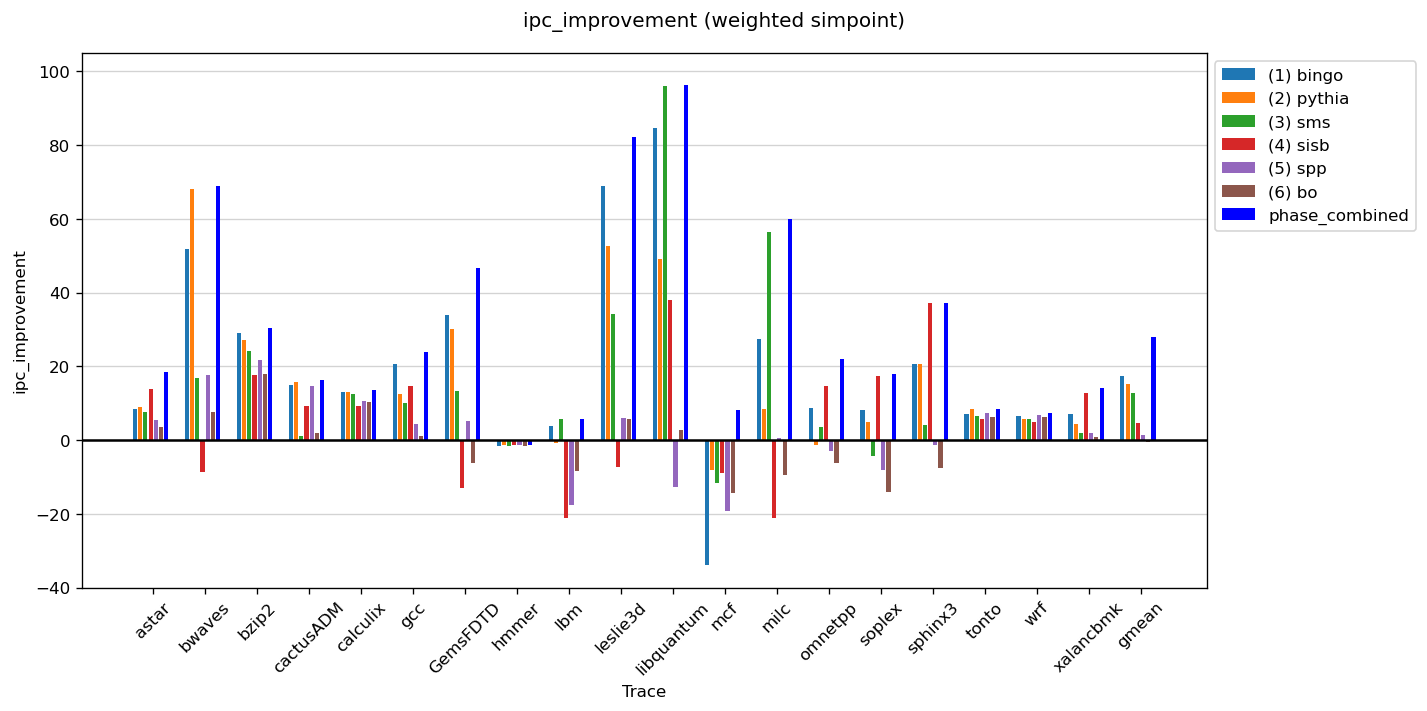

In [73]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           prefetchers=spec_top_single,
                           benchmarks=spec,
                           ymin=-40, ymax=105, dpi=120)
plt.savefig('plots/zoo-stats/ipc_improvement_single_spec.pdf')

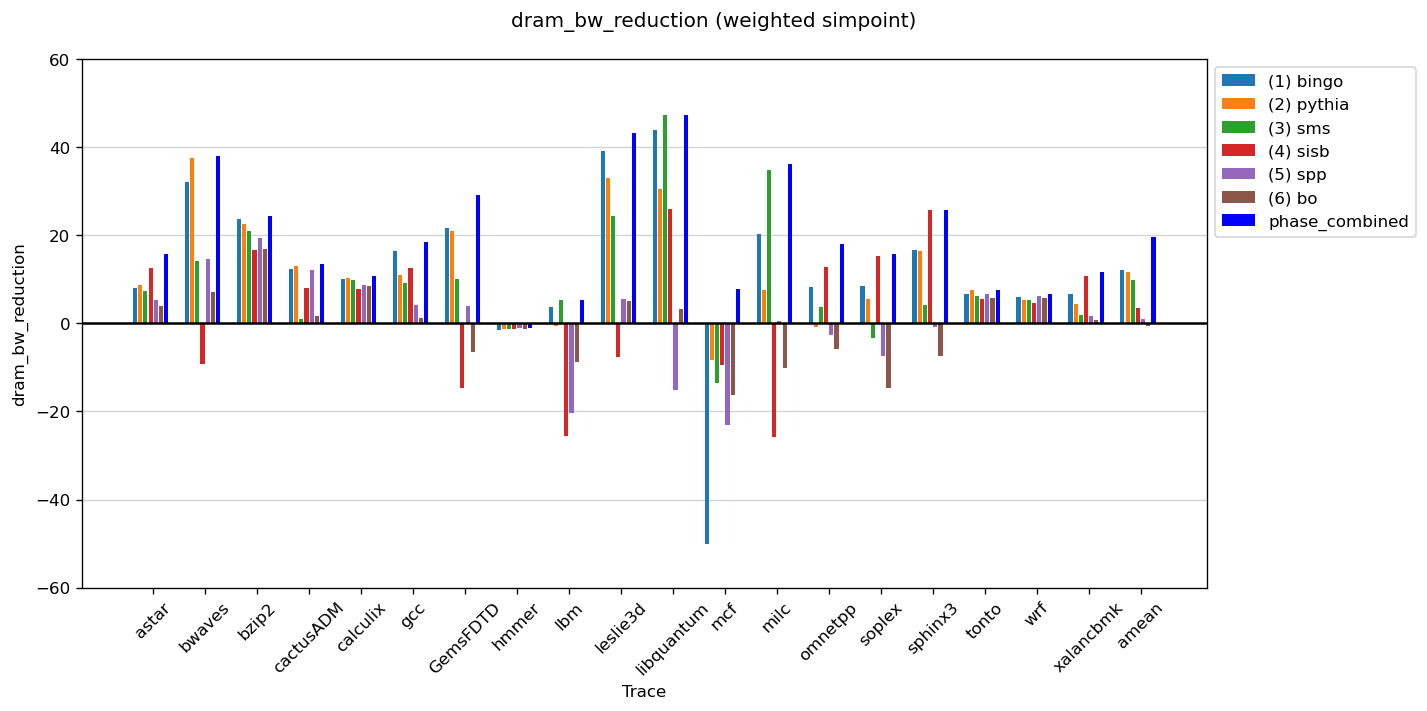

In [74]:
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='weighted',
                           prefetchers=spec_top_single,
                           benchmarks=spec,
                           ymin=-60, ymax=60, dpi=120)
plt.savefig('plots/zoo-stats/dram_bw_reduction_single_spec.pdf')

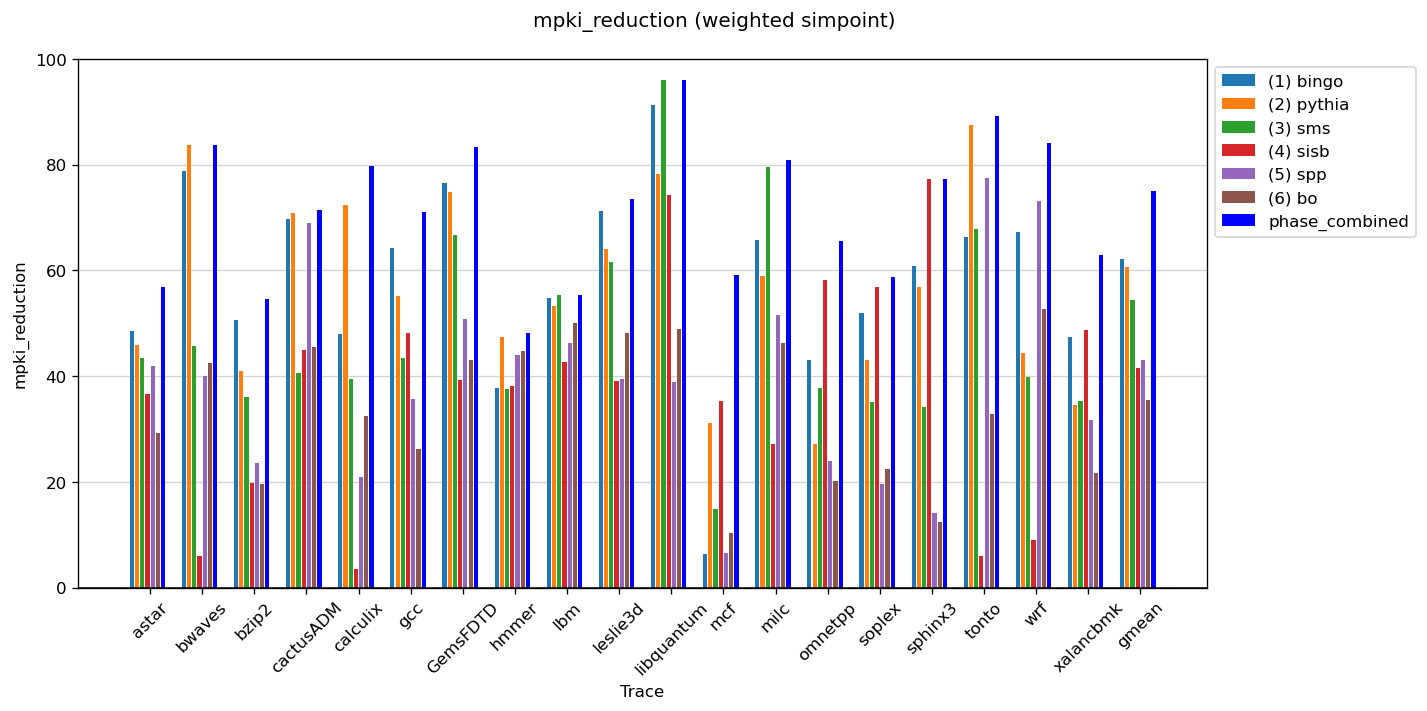

In [75]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           prefetchers=spec_top_single,
                           benchmarks=spec,
                           ymin=0, ymax=100, dpi=120)
plt.savefig('plots/zoo-stats/mpki_reduction_single_spec.pdf')

---
## GAP cumulative statistics

### Top 5
- Note: Weighted vs. longest simpoint doesn't matter here, since all gap traces are single-simpoint.

In [76]:
gap_top_5 = utils.rank_prefetchers(df[df.trace.isin(gap)], 'ipc_improvement', 5)
gap_top_5

['bingo_sisb', 'bingo_pythia', 'bingo_spp', 'bingo_sms', 'bingo_bo']

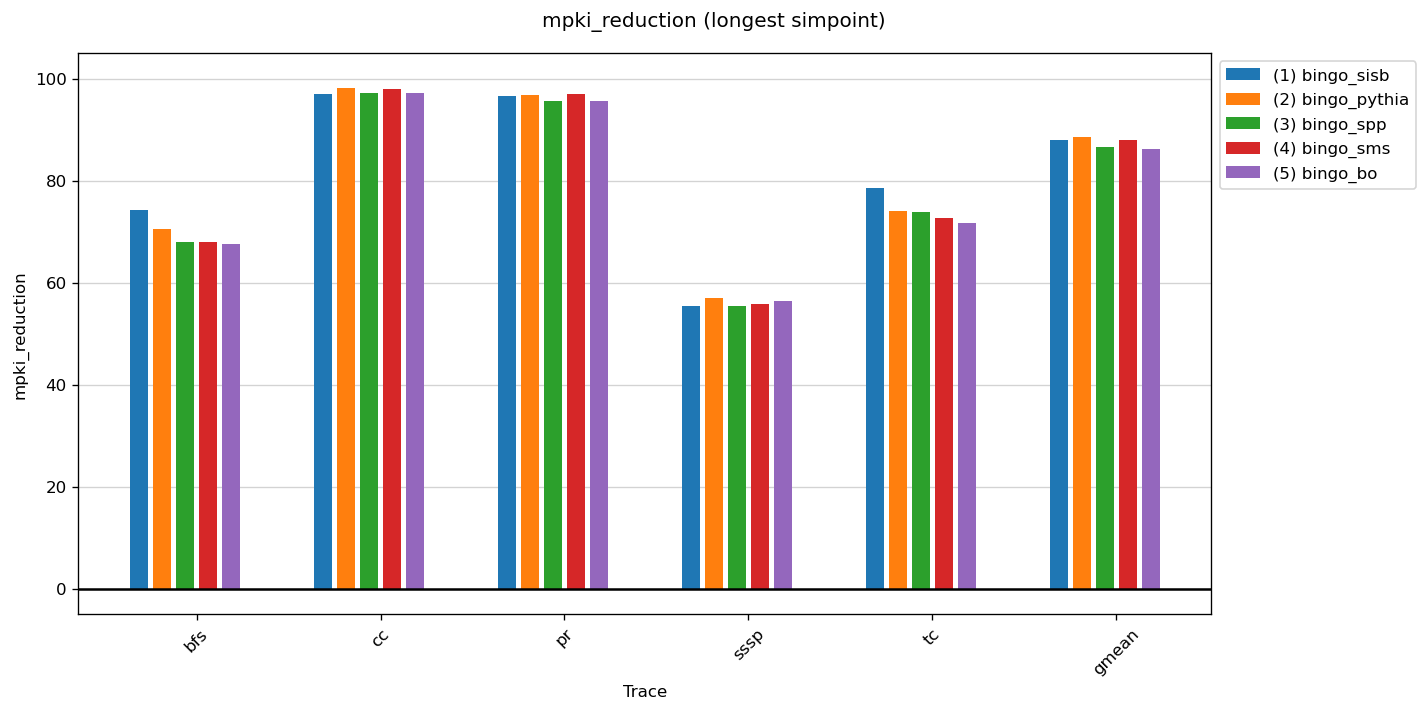

In [77]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='longest',
                           prefetchers=gap_top_5,
                           benchmarks=gap,
                           ymin=-5, ymax=105, dpi=120)
plt.savefig('plots/zoo-stats/mpki_reduction_5_gap.pdf')

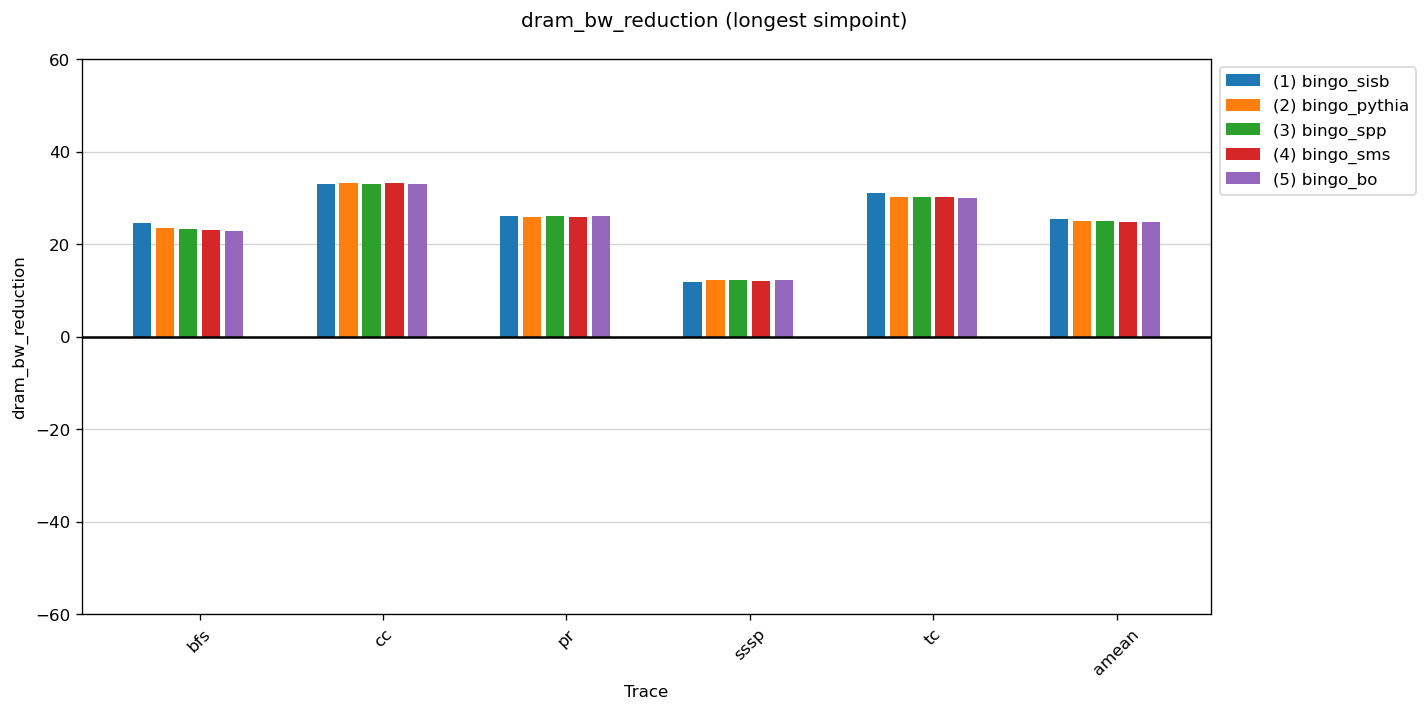

In [78]:
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='longest',
                           prefetchers=gap_top_5,
                           benchmarks=gap,
                           ymin=-60, ymax=60, dpi=120)
plt.savefig('plots/zoo-stats/dram_bw_reduction_5_gap.pdf')

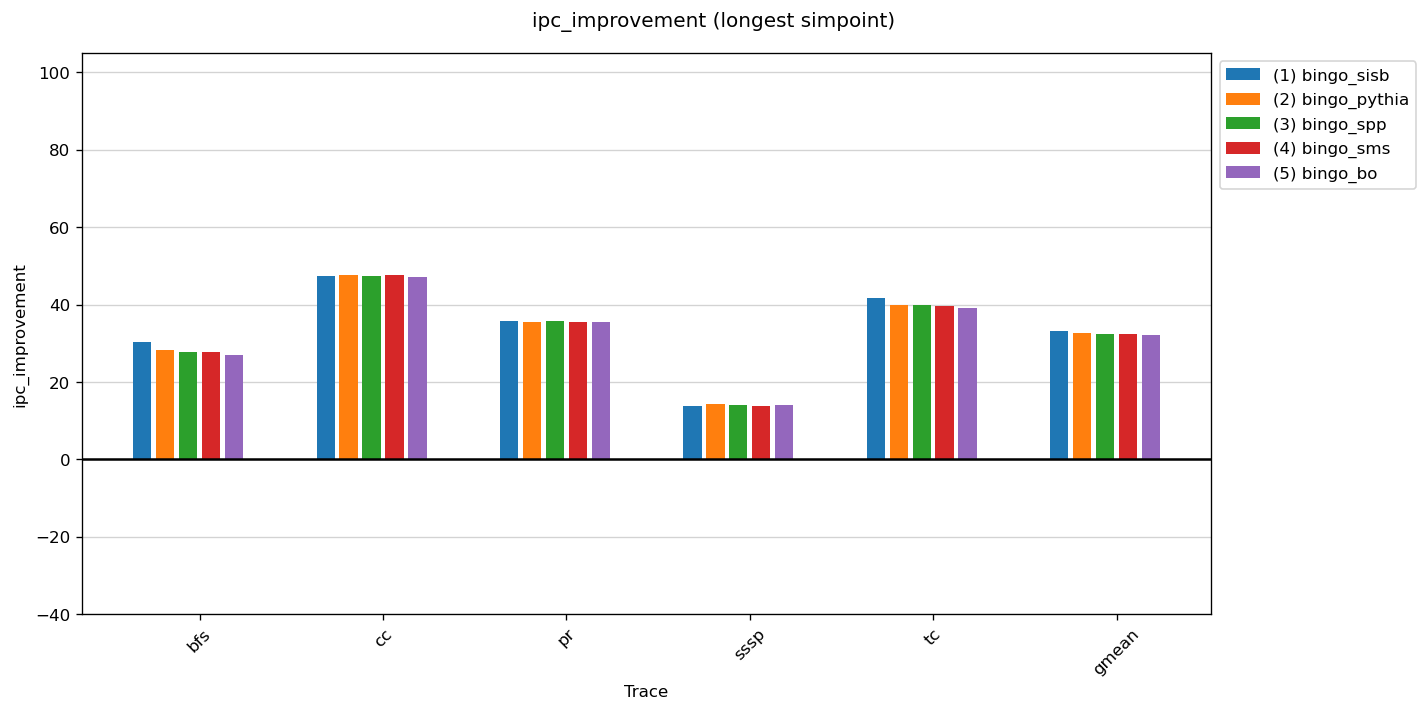

In [79]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='longest',
                           prefetchers=gap_top_5,
                           benchmarks=gap,
                           ymin=-40, ymax=105, dpi=120)
plt.savefig('plots/zoo-stats/ipc_improvement_5_gap.pdf')

### Weighted simpoint, all single prefetchers

In [80]:
gap_top_single = utils.rank_prefetchers(
    df[df.trace.isin(gap) & df.prefetcher.isin(['sisb', 'sms', 'bingo', 'bo', 'spp', 'pythia'])], 
    'ipc_improvement', 6
)
gap_top_single

['bingo', 'pythia', 'sms', 'spp', 'sisb', 'bo']

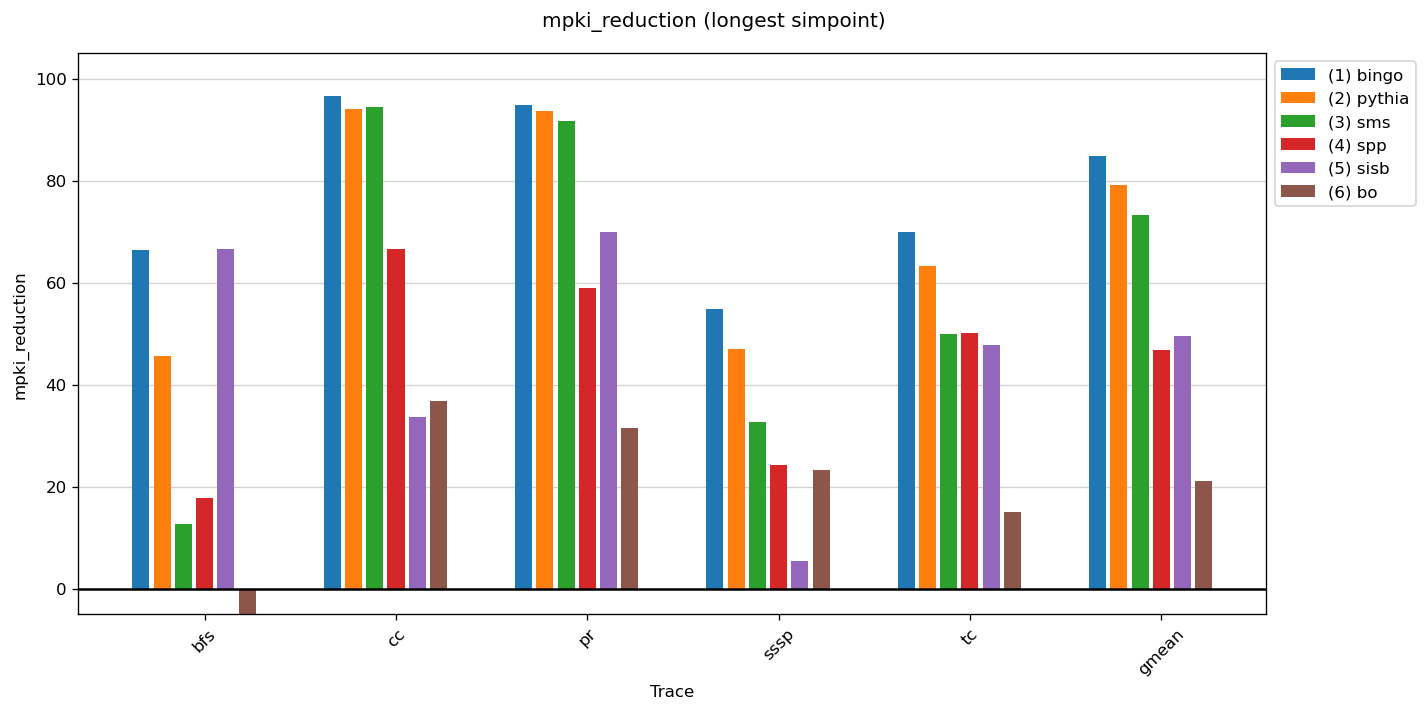

In [81]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='longest',
                           prefetchers=gap_top_single,
                           benchmarks=gap,
                           ymin=-5, ymax=105, dpi=120)
plt.savefig('plots/zoo-stats/mpki_reduction_single_gap.pdf')

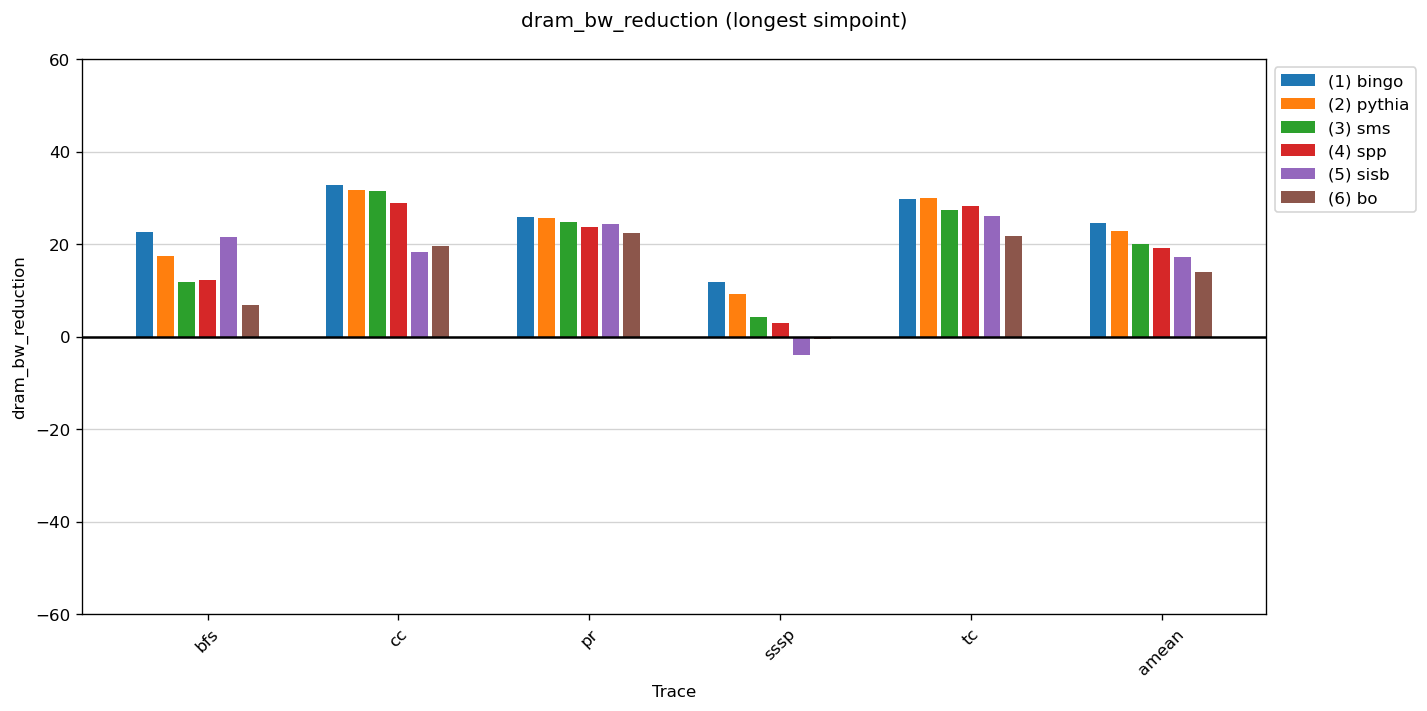

In [82]:
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='longest',
                           prefetchers=gap_top_single,
                           benchmarks=gap,
                           ymin=-60, ymax=60, dpi=120)
plt.savefig('plots/zoo-stats/dram_bw_reduction_single_gap.pdf')

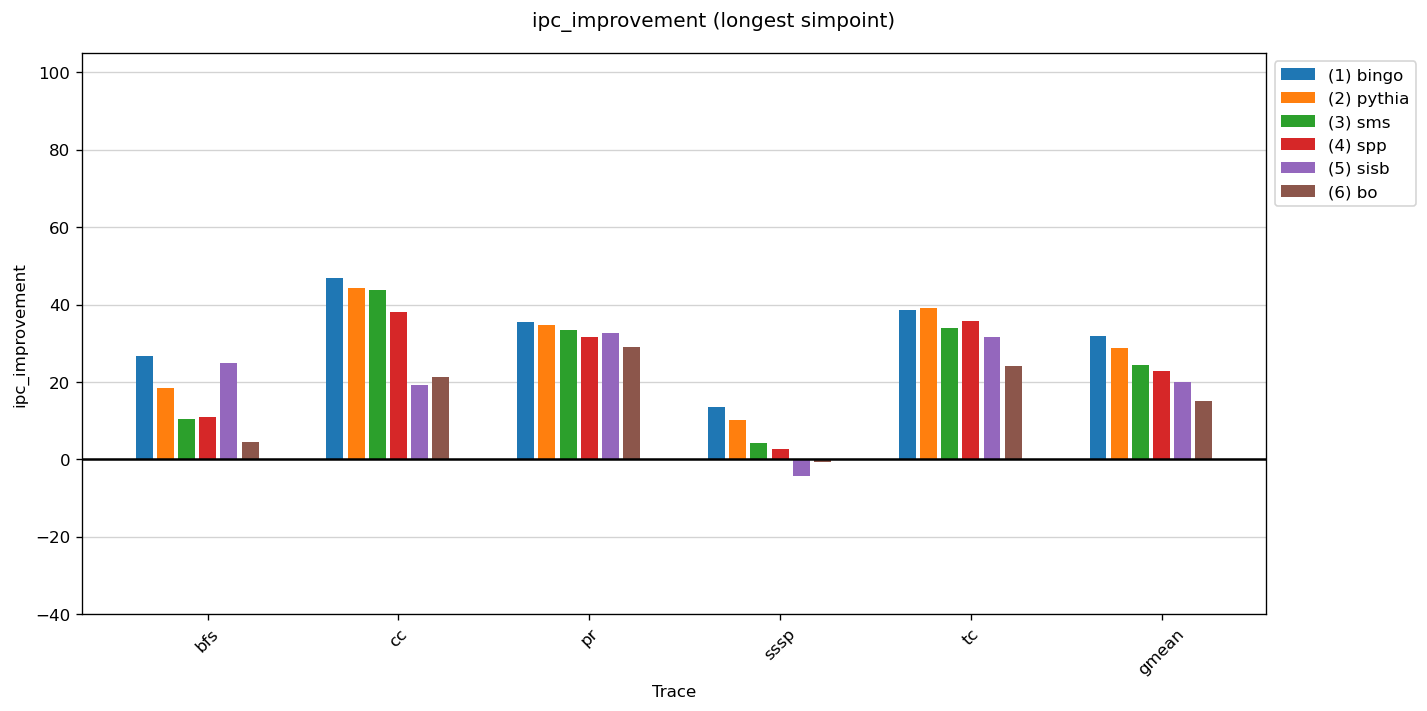

In [83]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='longest',
                           prefetchers=gap_top_single,
                           benchmarks=gap,
                           ymin=-40, ymax=105, dpi=120)
plt.savefig('plots/zoo-stats/ipc_improvement_single_gap.pdf')

---
## CloudSuite cumulative statistics

### Weighted simpoint, top 5

In [84]:
cs_top_5 = utils.rank_prefetchers(df[df.trace.isin(cloudsuite)], 'ipc_improvement', 5)
cs_top_5

['sisb_pythia', 'bingo_pythia', 'bingo_sisb', 'sms_pythia', 'bingo_spp']

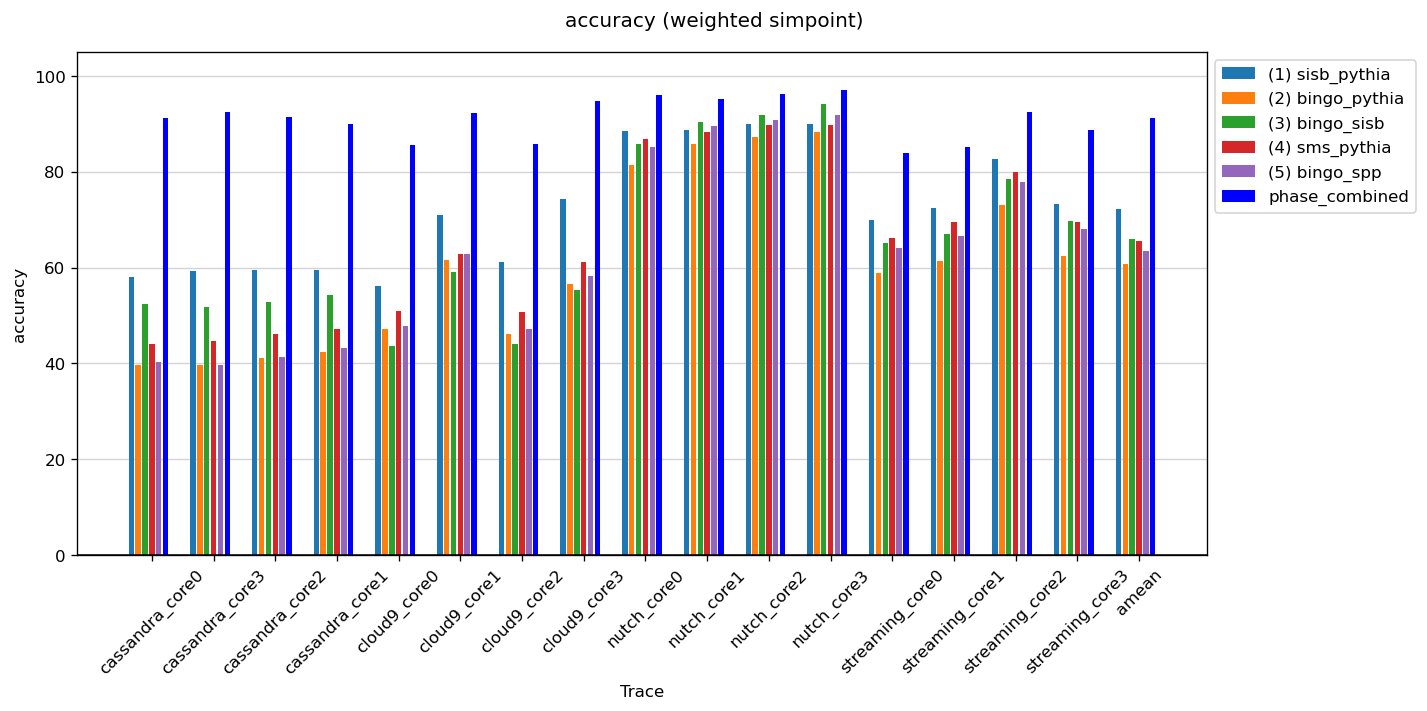

In [85]:
plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                           prefetchers=cs_top_5,
                           benchmarks=cloudsuite,
                           ymin=0, ymax=105, dpi=120)

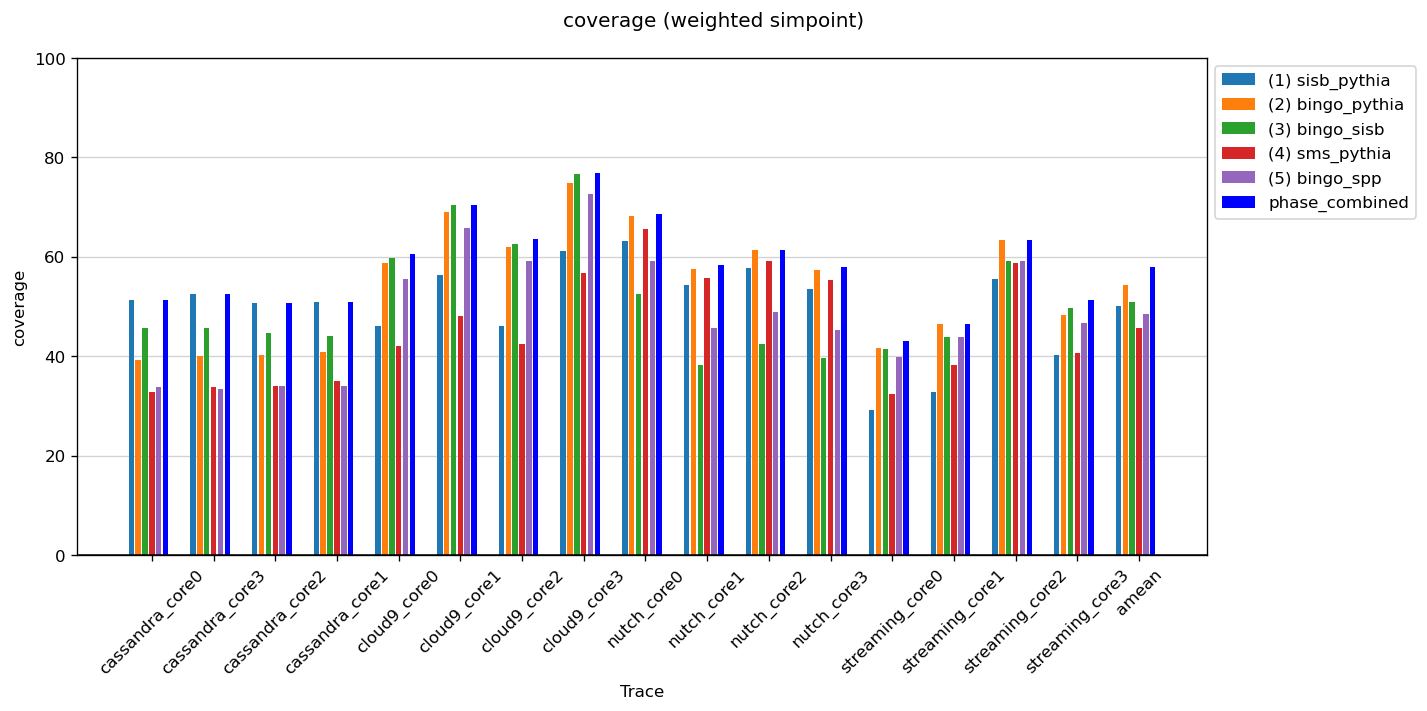

In [86]:
plot_cumulative_statistics(df, weights, metric='coverage', method='weighted',
                           prefetchers=cs_top_5,
                           benchmarks=cloudsuite,
                           ymin=0, ymax=100, dpi=120)

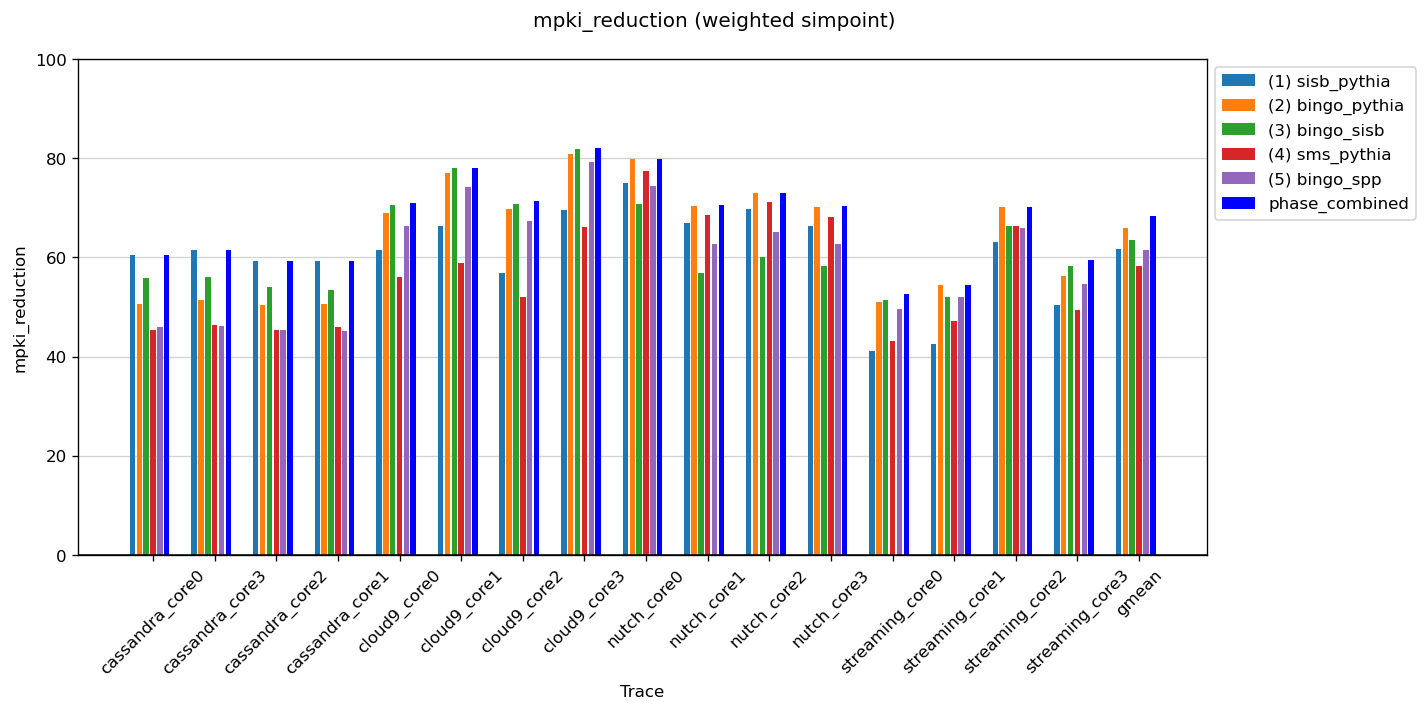

In [87]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           prefetchers=cs_top_5,
                           benchmarks=cloudsuite,
                           ymin=0, ymax=100, dpi=120)
plt.savefig('plots/zoo-stats/mpki_reduction_5_cloudsuite.pdf')

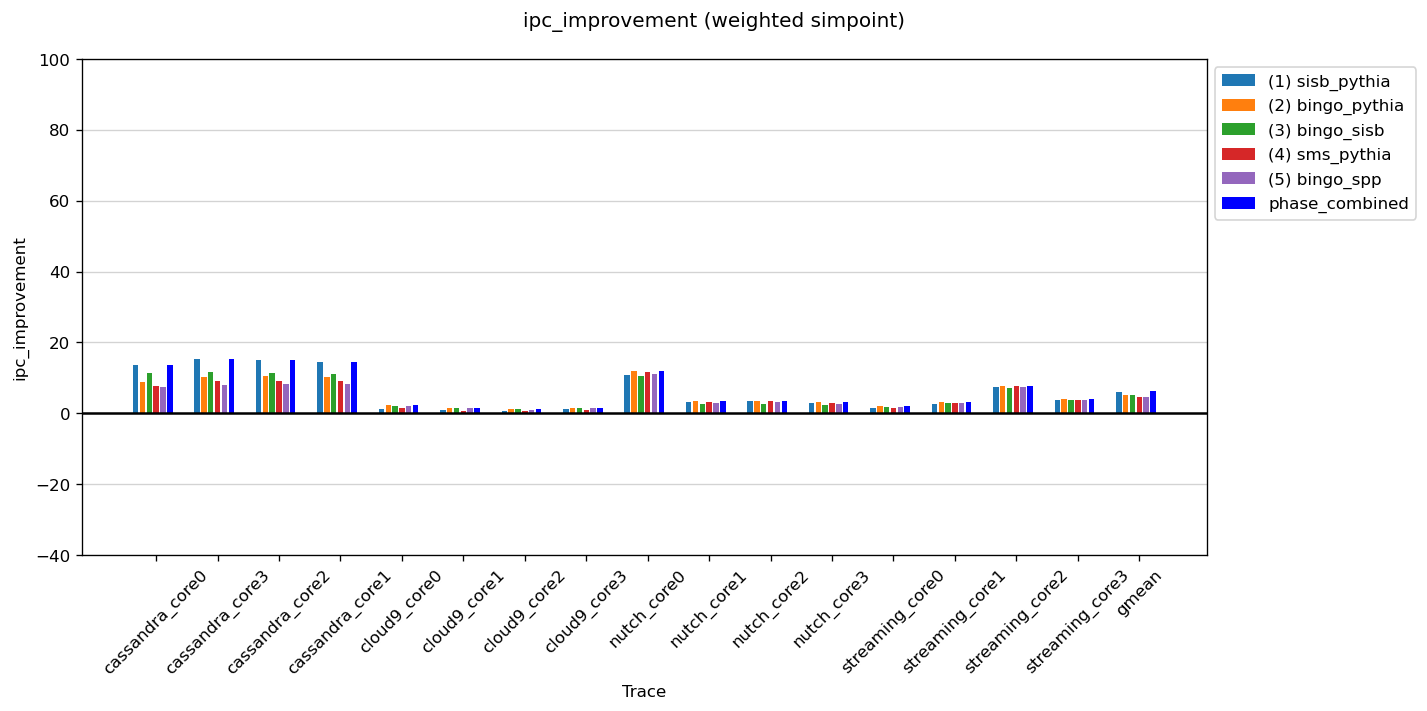

In [88]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           prefetchers=cs_top_5,
                           benchmarks=cloudsuite,
                           ymin=-40, ymax=100, dpi=120)
plt.savefig('plots/zoo-stats/ipc_improvement_5_cloudsuite.pdf')

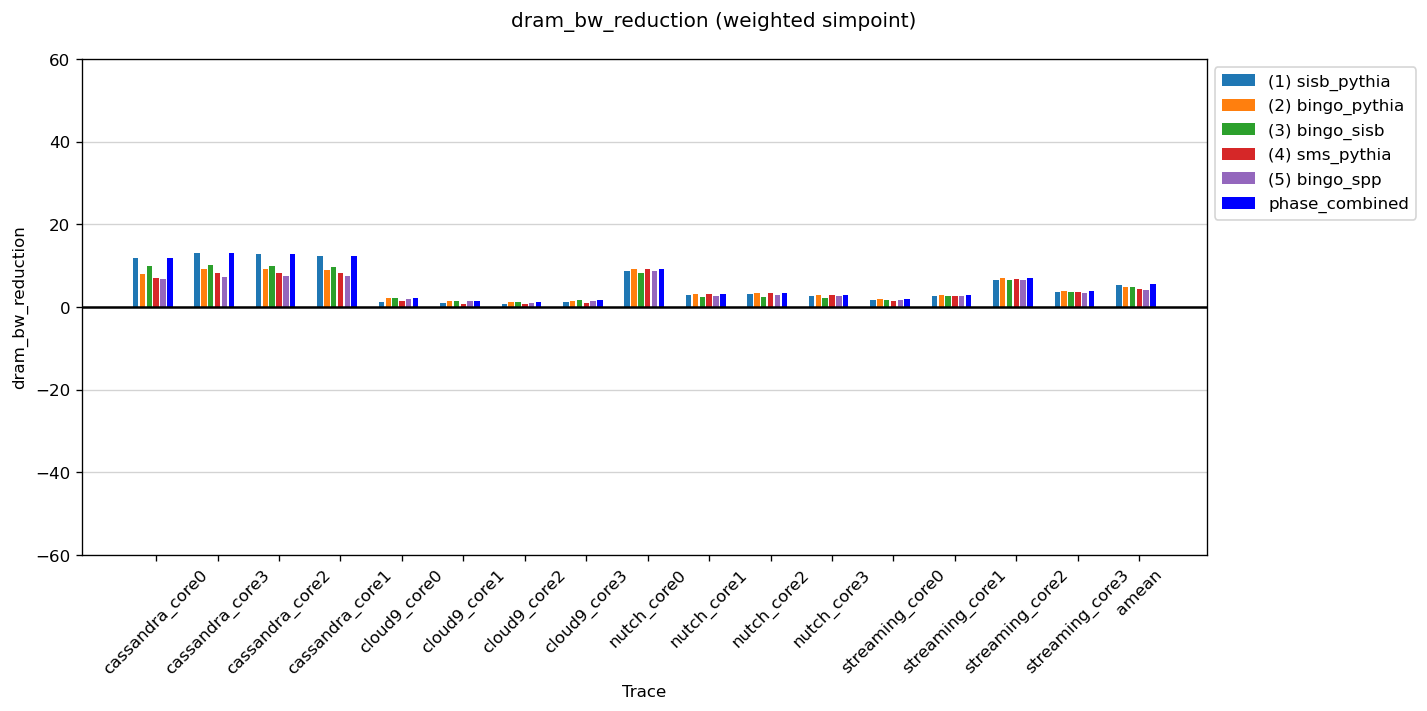

In [89]:
plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='weighted',
                           prefetchers=cs_top_5,
                           benchmarks=cloudsuite,
                           ymin=-60, ymax=60, dpi=120)
plt.savefig('plots/zoo-stats/dram_bw_reduction_5_cloudsuite.pdf')